# Parse saturation curve data

In [1]:
from thermotools.plot import *
import os, glob
import numpy as np
from matplotlib.ticker import MultipleLocator

from thermotools import phase
from thermotools import water
from thermotools import moles
from thermotools import get_inpdir, get_gendir, empty_dir

tmin = 0.5
dt   = 0.1

elem_table = moles.read_elements()

datdir = os.path.join(get_gendir(), "sat", "dat")
empty_dir(datdir)

empty_dir(os.path.join(get_gendir(), "sat", "plt"))

In [2]:
def write_csv(gas,ts,ps):
    X = np.array([ts,ps]).T
    head = "T [K] , P_sat [Pa]"
    fpath = datdir+"/%s_sat.csv"%gas

    np.savetxt(fpath, X, fmt="%.9e", delimiter=',', header=head)

def write_tripcrit(gas, t_trip, t_crit):

    X = [t_trip]
    head = "T_trip [K]"
    fpath = datdir+"/%s_trip.csv"%gas
    np.savetxt(fpath, X, fmt="%.9e", delimiter=',', header=head)

    X = [t_crit]
    head = "T_crit [K]"
    fpath = datdir+"/%s_crit.csv"%gas
    np.savetxt(fpath, X, fmt="%.9e", delimiter=',', header=head)

In [3]:
# Main gases
for gas in phase.gases.keys():
    print(gas)
    mmw = moles.mmw_from_formula(gas, elem_table)
    gdict = phase.gases[gas]

    fname = os.path.join(get_gendir(),"lv","dat")+"/%s.csv"%gas
    if os.path.exists(fname):
        t_arr = np.arange(tmin, gdict["T_crit"], dt)
        t_arr = np.concatenate((t_arr, [gdict["T_crit"]]))
        p_arr = [phase.cc_psat(t, gas, mmw) for t in t_arr]

        write_csv(gas, t_arr, p_arr)
        write_tripcrit(gas, gdict["T_trip"], gdict["T_crit"])

        print("    ok")
    else:
        print("    no Lvap data")


NH3
    ok
CO2
    ok
CH4
    ok
H2
    ok
N2
    ok
SO2
    ok
N2O
    no Lvap data
O2
    ok
H2S
    no Lvap data
O3
    no Lvap data
HCN
    ok
SiH4
    no Lvap data


In [4]:
# Water
t_arr = np.arange(tmin, water.T_crit, dt)
t_arr = np.concatenate((t_arr, [water.T_crit]))
arr_p = [water.psat_both(t) for t in t_arr]

write_csv("H2O",t_arr, arr_p)
write_tripcrit("H2O", water.T_trip, water.T_crit)

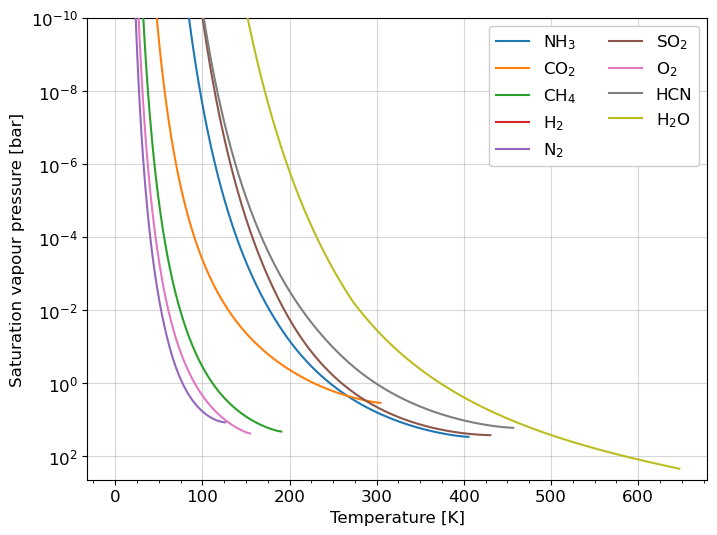

In [5]:
plt.close("all")


fig,ax = plt.subplots(1,1, figsize=(8,6))

files = glob.glob(datdir+"/*_sat.csv")

ymax = 1.0
for i,f in enumerate(files):
    form = moles.formula_from_path(f).split("_")[0]
    data = np.loadtxt(f, delimiter=',').T

    ls='solid'
    if i > 9:
        ls='dashed'
    if i > 18:
        ls='dotted'

    if len(data[0]) < 3:
        continue

    x = data[0]
    y = data[1]*1e-5
    ymax = max(ymax, np.amax(y))
    l = ax.plot(x, y, label=pretty_name(form), ls=ls, zorder=3)[0]

ax.set(xlabel="Temperature [K]", ylabel="Saturation vapour pressure [bar]")
ax.legend(ncols=2, framealpha=1.0)

ax.xaxis.set_minor_locator(MultipleLocator(25))

ax.grid(zorder=0, alpha=0.5)

ax.set_yscale("log")
ax.set_ylim(top=1e-10, bottom=ymax*2)

fig.savefig(os.path.join(get_gendir(),"sat","plt","all.png"), bbox_inches='tight', dpi=350)
plt.show()